# Assignment 02
Name: Yan Qinlin  
SID: 12231096  
Due: 2022/11/1

In [1]:
import random
from math import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import netCDF4
import xarray as xr
%matplotlib inline

**Ref:** All the programming details were referred to the handout of course ESE5023 by professor Zhu (https://zhu-group.github.io/ese5023).

## 1. Significant earthquaes since 2150 B.C.

In [2]:
#读入数据并查看
Sig_Eqs = pd.read_csv("earthquakes-2022-10-18_20-41-39_+0800.tsv",delimiter='\t')
Sig_Eqs=Sig_Eqs.drop([0])
Sig_Eqs.head()

,Search Parameters,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Location Name,...,Total Missing,Total Missing Description,Total Injuries,Total Injuries Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description,Total Houses Damaged,Total Houses Damaged Description
1,NaN,-2150.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,"JORDAN: BAB-A-DARAA,AL-KARAK",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,-2000.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,SYRIA: UGARIT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,-2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TURKMENISTAN: W,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN
4,NaN,-1610.0,NaN,NaN,NaN,NaN,NaN,3.0,1351.0,GREECE: THERA ISLAND (SANTORINI),...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
5,NaN,-1566.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,ISRAEL: ARIHA (JERICHO),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.1

In [3]:
#因为地点一列有国家、省两条信息，所以先新建一列只存放国家名称
Sig_Eqs['nation'] = Sig_Eqs['Location Name'].str.split(': ',expand=True)[0]
#data cleaning，把NaN变成0
Sig_Eqs['Deaths'].fillna(value = 0)
#按照国家分类统计死亡人数
ser = Sig_Eqs.groupby(['nation']).sum()['Deaths']

#打印死亡人数最多的前二十国家
de_num = Sig_Eqs.groupby(['nation']).sum().sort_values('Deaths',ascending=False)['Deaths']
print(de_num[0:20])

nation
CHINA           2075019.0
TURKEY          1094479.0
IRAN             995403.0
ITALY            498477.0
SYRIA            369224.0
HAITI            323474.0
AZERBAIJAN       317219.0
JAPAN            277142.0
ARMENIA          191890.0
ISRAEL           160120.0
PAKISTAN         145080.0
ECUADOR          135479.0
IRAQ             120200.0
TURKMENISTAN     117412.0
PERU             101511.0
PORTUGAL          83506.0
GREECE            79278.0
CHILE             64269.0
INDIA             61940.0
TAIWAN            57023.0
Name: Deaths, dtype: float64


### 1.2

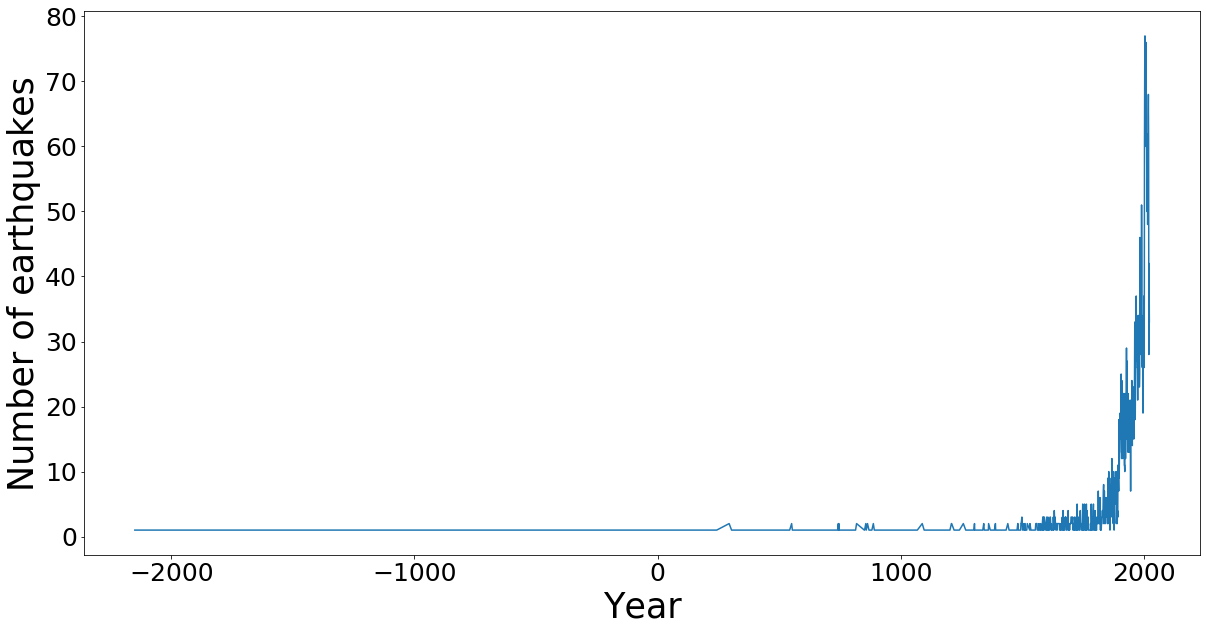

In [4]:
#震级为缺失值的删掉，修改了原数据
Sig_Eqs.dropna(axis=0,subset = ['Mag'],inplace=True)
#筛选出震级大于3的,按年统计次数并画出
plt.figure()
ax= Sig_Eqs.loc[Sig_Eqs['Mag']>3].groupby(['Year']).count()['Mag'].plot(figsize=(20,10))
ax.set_xlabel('Year',fontsize=35)
ax.set_ylabel('Number of earthquakes',fontsize=35)
plt.tick_params(labelsize=25)

The total number of earthquakes with magnitude larger than 3.0 worldwide each year has a clear trend of growth, and it significantly rise after the industrial revolution. The reason of the rise trend is inferred to be related to the development of seismic detection technology. The number of earthquakes detected is positively related to the technology development, in other words, the more advance the technology, the more earthquakes will be detected. This can also explain the increase of the slope since the development of science and technology is getting faster with time.

### 1.3

In [147]:
#1.2中修改了元数据，1.3运行前要重新执行此前的chunk
def CountEq_LargestEq(country):
    #计算该国地震的总次数,Year数据没有缺失，可以用作计数
    Eq_number = Sig_Eqs.groupby(['nation']).count()['Year'].loc[country]
    
    #row储存每个国家最严重的地震信息，Mag和MMI共同判断地震程度
    row = Sig_Eqs.loc[ Sig_Eqs['nation']==country].sort_values(["Mag","MMI Int"], ascending=[0,0]).iloc[0]
    
    #缺失值替换为‘unknown’
    row.fillna(int(0),inplace=True)
    
    
    #将时间、地点信息分别存成一个str，date理解为年月日
    date = "%r-%d-%d"%(int(row.loc['Year']),row.loc['Mo'],row.loc['Dy'])
    loc = "Lat%r,Lon%r"%(round(row.loc['Latitude'],2),round(row.loc['Longitude'],2))

    return ([Eq_number, date, loc])

In [350]:
#删去没有国家信息的行
Sig_Eqs.dropna(axis=0,subset = ['nation'],inplace=True)

#复制国家名称，之后作为函数的输入
Sig_Eqs['Country']=Sig_Eqs['nation']

#按照国家统计，同时保留country列
na_df = Sig_Eqs.groupby(['nation']).max()

#初始化一些新列
na_df['Eq_num']=0
na_df['Date']='N'
na_df['Location']='N'

#每个国家都调用上个chunk的函数，输出储存到刚刚新建的三个新列
for i in range(na_df.shape[0]):
    na_df['Eq_num'][i]=CountEq_LargestEq(na_df['Country'].iloc[i])[0]
    na_df['Date'][i]=CountEq_LargestEq(na_df['Country'].iloc[i])[1]
    na_df['Location'][i]=CountEq_LargestEq(na_df['Country'].iloc[i])[2]

#降序排列后打印该国地震次数、最大地震发生的时间和地点
na_df.sort_values("Eq_num", ascending=False).iloc[1: ,40:43]


D:\anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Eq_num,Date,Location
nation,,,
INDONESIA,388,2004-12-26,"Lat3.32,Lon95.85"
IRAN,384,856-12-22,"Lat36.2,Lon54.3"
JAPAN,351,2011-3-11,"Lat38.3,Lon142.37"
ITALY,330,1915-1-13,"Lat42.0,Lon13.5"
TURKEY,320,1916-1-24,"Lat41.0,Lon37.0"
...,...,...,...
LAOS,1,2007-5-16,"Lat20.5,Lon100.75"
LAOS; VIETNAM,1,2001-2-19,"Lat21.4,Lon102.72"
"LHOKNGA, ACEH",1,1922-7-8,"Lat5.5,Lon95.2"


**Ref:** The data was downloaded from NOAA (https://www.ngdc.noaa.gov/hazel/view/hazards/earthquake/event-data). Besides, the usage of placeholder (%) in Python was referred to the blog by *Dream____Fly* (https://blog.csdn.net/Dream____Fly/article/details/105088932).


## 2. Wind speed in Shenzhen during the past 10 years

In [47]:
#搜索发现TMP数据采集信息只有四类：1, 2, 5, 9， +9999表示missing
#e.g.+0213,1 表示+21.3℃，且数据通过所有审查
#读入数据并查看
air_df = pd.read_csv("Baoan_Weather_1998_2022.csv")

#删除气温missing的行
air_df.drop(air_df[air_df['TMP'].str.contains('9999')].index,inplace=True)

#创建新行，只存放年月信息，str类型
air_df['YearMo'] = air_df['DATE'].str[0:7]

#气温存成一个float列，并调整单位
air_df['Air_T'] = air_df['TMP'].str[2:5].astype(float)/10.

#按照年月统计，求气温平均值（保留两位小数）
air_df1 = air_df.groupby(['YearMo']).mean()
air_df1['Air_T'] = round(air_df1['Air_T'],2)
air_df1.head(-10)

D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4,8,9,10,11,14,15,24,25,27,29,31,34,37,38,40,41,45,49,50) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STATION,SOURCE,IA1,SOURCE.1,WG1,Air_T
YearMo,,,,,,
1998-01,59493099999,4,NaN,4,NaN,15.23
1998-02,59493099999,4,NaN,4,NaN,16.88
1998-03,59493099999,4,NaN,4,NaN,19.97
1998-04,59493099999,4,NaN,4,NaN,25.23
1998-05,59493099999,4,NaN,4,NaN,27.10
...,...,...,...,...,...,...
2021-08,59493099999,4,NaN,4,NaN,29.23
2021-09,59493099999,4,NaN,4,NaN,29.80
2021-10,59493099999,4,NaN,4,NaN,25.32


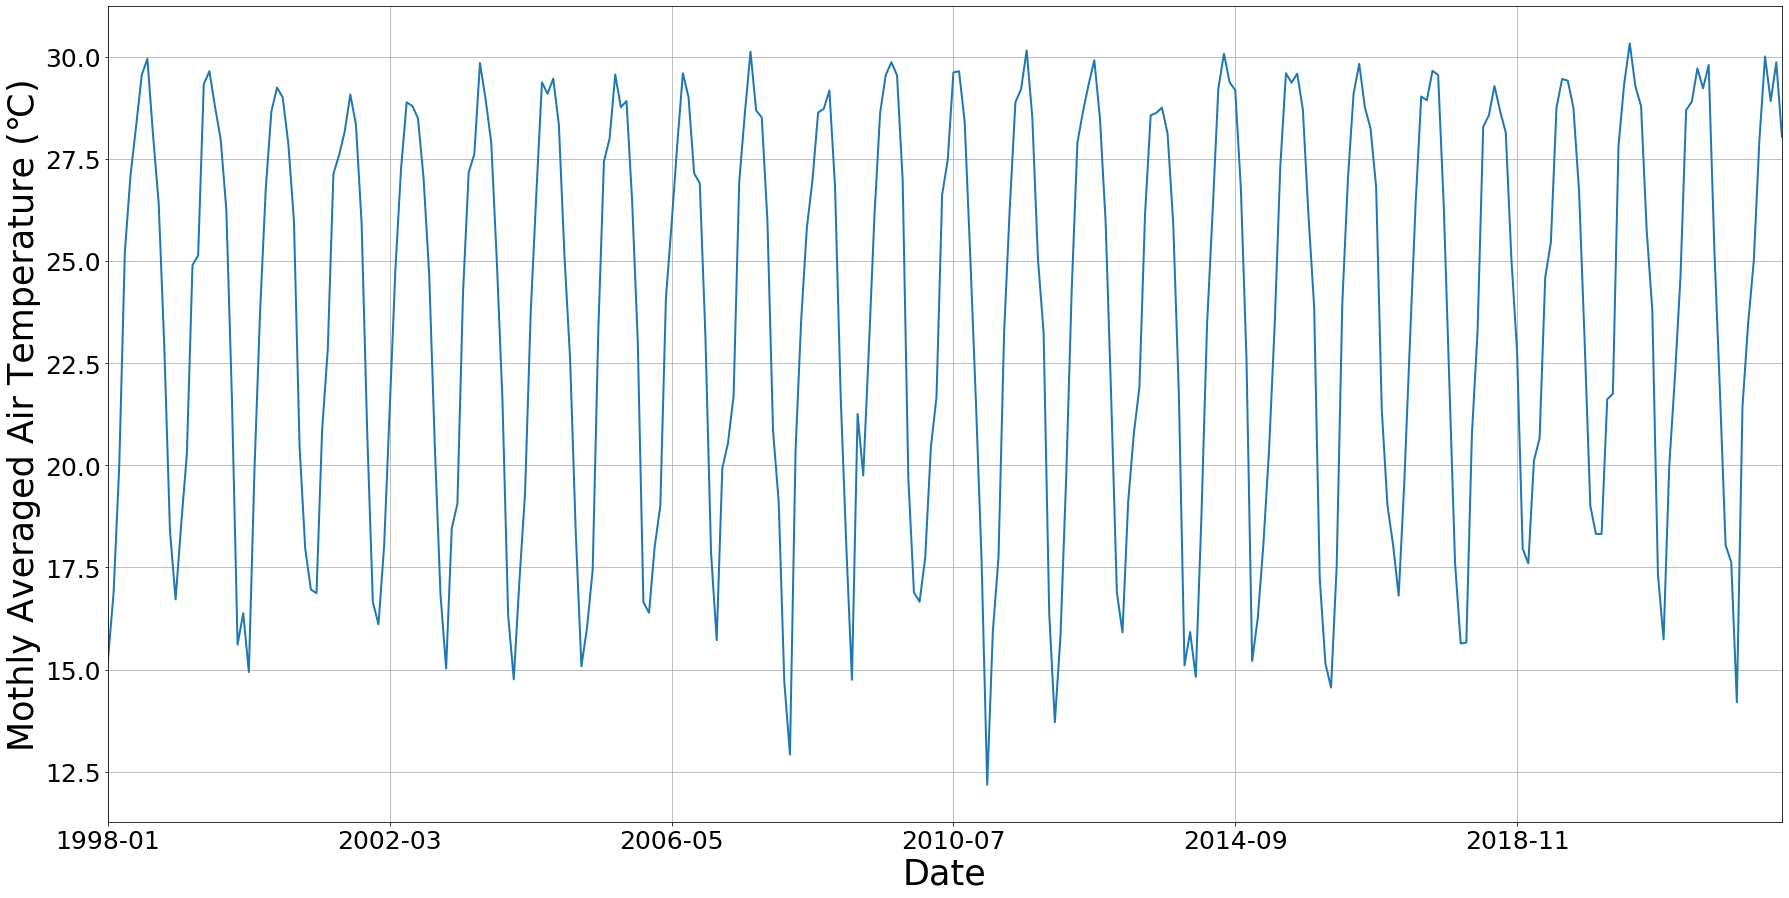

In [81]:
#画图方法一：
#画月均气温的时间序列图
plt.figure()
ax= air_df1['Air_T'].plot(figsize=(30,15),lw=2)
ax.set_xlabel('Date',fontsize=35)
ax.set_ylabel('Mothly Averaged Air Temperature (℃)',fontsize=35)
plt.grid('.')
#plt.xlim(xlabel[0],xlabel[-1])
plt.tick_params(labelsize=25)

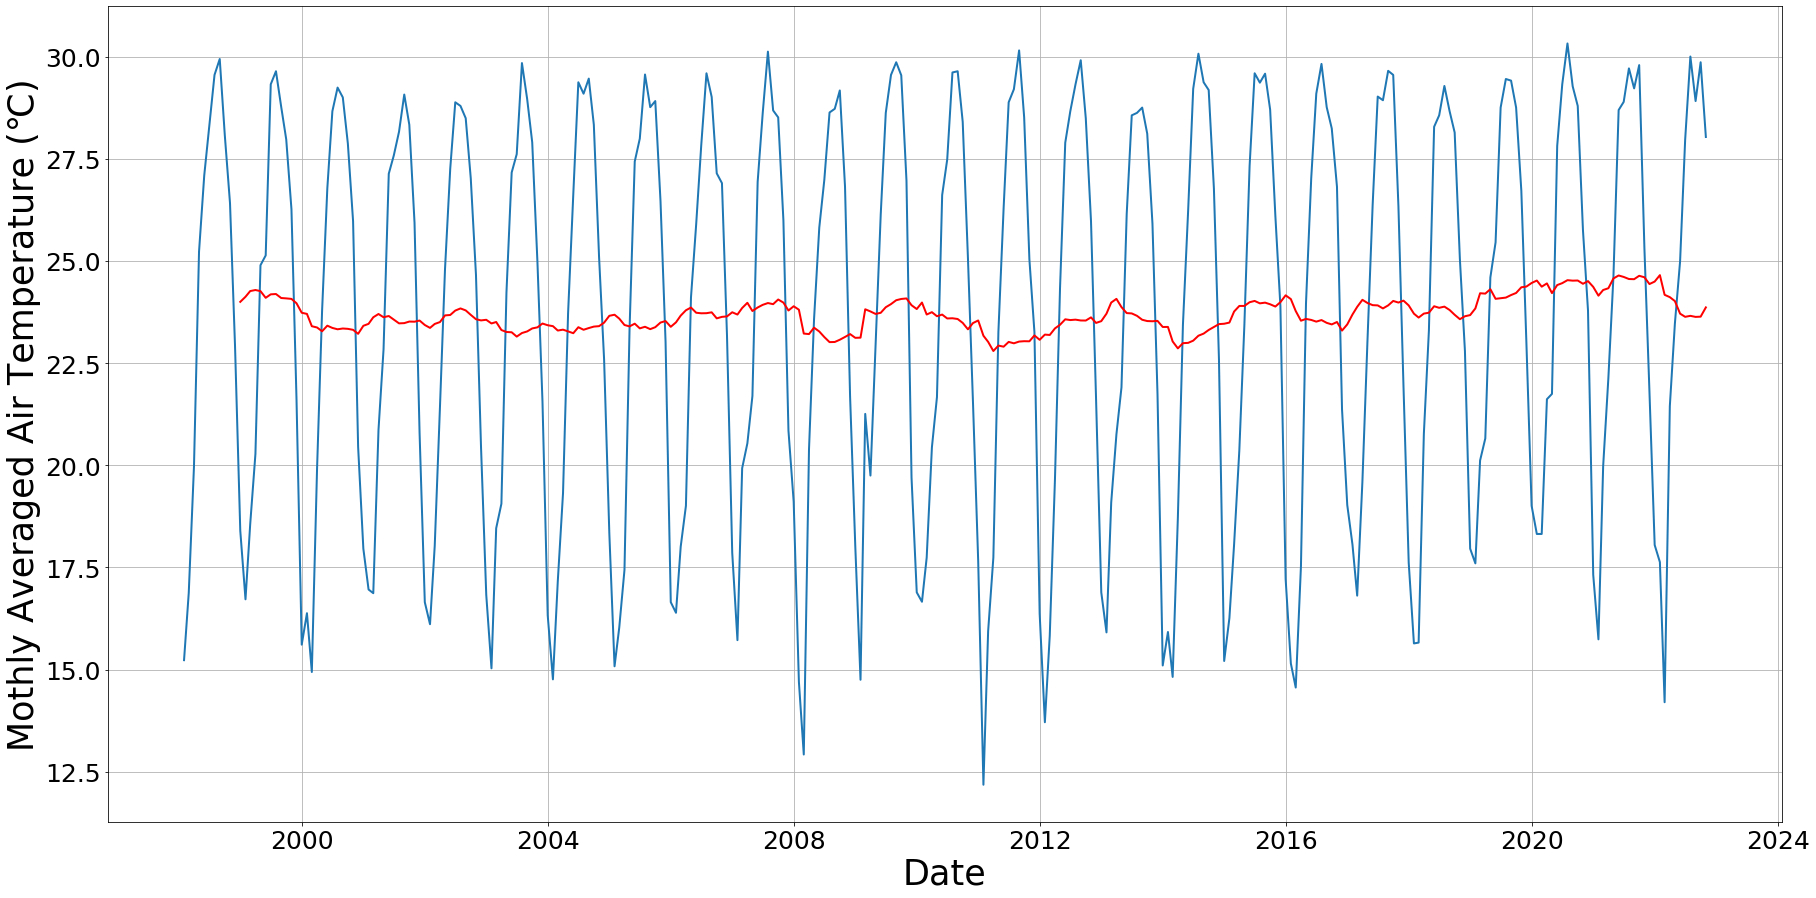

In [82]:
#画图方法二（可以画出平均线）：
#构造新的series
value = pd.Series(
    air_df1['Air_T'].values,
    index=pd.date_range(start="1998-1-1", periods = 298, freq="M"),
)

#滑动平均后看趋势
ma = value.rolling(12).mean()
#mstd = value.rolling(10).std()
plt.figure(figsize=(30,15));
plt.plot(value.index, value,lw=2)
plt.plot(ma.index, ma, "r",lw=2)
#plt.fill_between(mstd.index, ma - 2 * mstd, ma + 2 * mstd, color="b", alpha=0.2)

plt.xlabel('Date',fontsize=35)
plt.ylabel('Mothly Averaged Air Temperature (℃)',fontsize=35)
plt.grid()
plt.tick_params(labelsize=25)

As shown in the figure above, monthly averaged air temperature is a periodic wave curve with the period of one year. Moreover, as shown by the red line, a tiny increase trend of the air temperature can be observed qualitatively.

**Ref:** The original data is from NOAA (https://www.ncei.noaa.gov/metadata/geoportal/rest/metadata/item/gov.noaa.ncdc%3AC00532/html). The useage of plot in Dataframe was referred to *pandas* website (https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html), and the usage of function *pandas.date_range()* was referred to the blog from *linda公馆*(https://blog.csdn.net/qq_40078436/article/details/107697091).

## 3. Global collection of hurricanes

In [5]:
df = pd.read_csv('ibtracs.ALL.list.v04r00.csv',
                 usecols=range(17),
                 skiprows=[1, 2], 
                 parse_dates=['ISO_TIME'],
                 na_values=['NOT_NAMED', 'NAME'])
df.info()

D:\anaconda\lib\site-packages\IPython\core\interactiveshell.py:3326: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707176 entries, 0 to 707175
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   SID         707176 non-null  object        
 1   SEASON      707176 non-null  int64         
 2   NUMBER      707176 non-null  int64         
 3   BASIN       582295 non-null  object        
 4   SUBBASIN    611577 non-null  object        
 5   NAME        382391 non-null  object        
 6   ISO_TIME    707176 non-null  datetime64[ns]
 7   NATURE      707176 non-null  object        
 8   LAT         707176 non-null  float64       
 9   LON         707176 non-null  float64       
 10  WMO_WIND    707176 non-null  object        
 11  WMO_PRES    707176 non-null  object        
 12  WMO_AGENCY  707176 non-null  object        
 13  TRACK_TYPE  707176 non-null  object        
 14  DIST2LAND   707176 non-null  int64         
 15  LANDFALL    707176 non-null  object        
 16  IF

### 3.1 

In [8]:
#打印风速最大的前10飓风名字
largest_df = df.groupby(['SID']).max().sort_values('WMO_WIND',ascending=False)['NAME']
print("The names of the 10 largest hurricanes according to wind speed are:")
print(largest_df[0:10].values)

The names of the 10 largest hurricanes according to wind speed are:
['RHONDA' 'TALIM' 'PERCY' 'INGRID' 'ADELINE:JULIET' 'NESAT' 'EMILY'
 'HAITANG' 'MAWAR' 'KATRINA']


D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  This is separate from the ipykernel package so we can avoid doing imports until


### 3.2 

D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  """


<Figure size 28800x720 with 0 Axes>

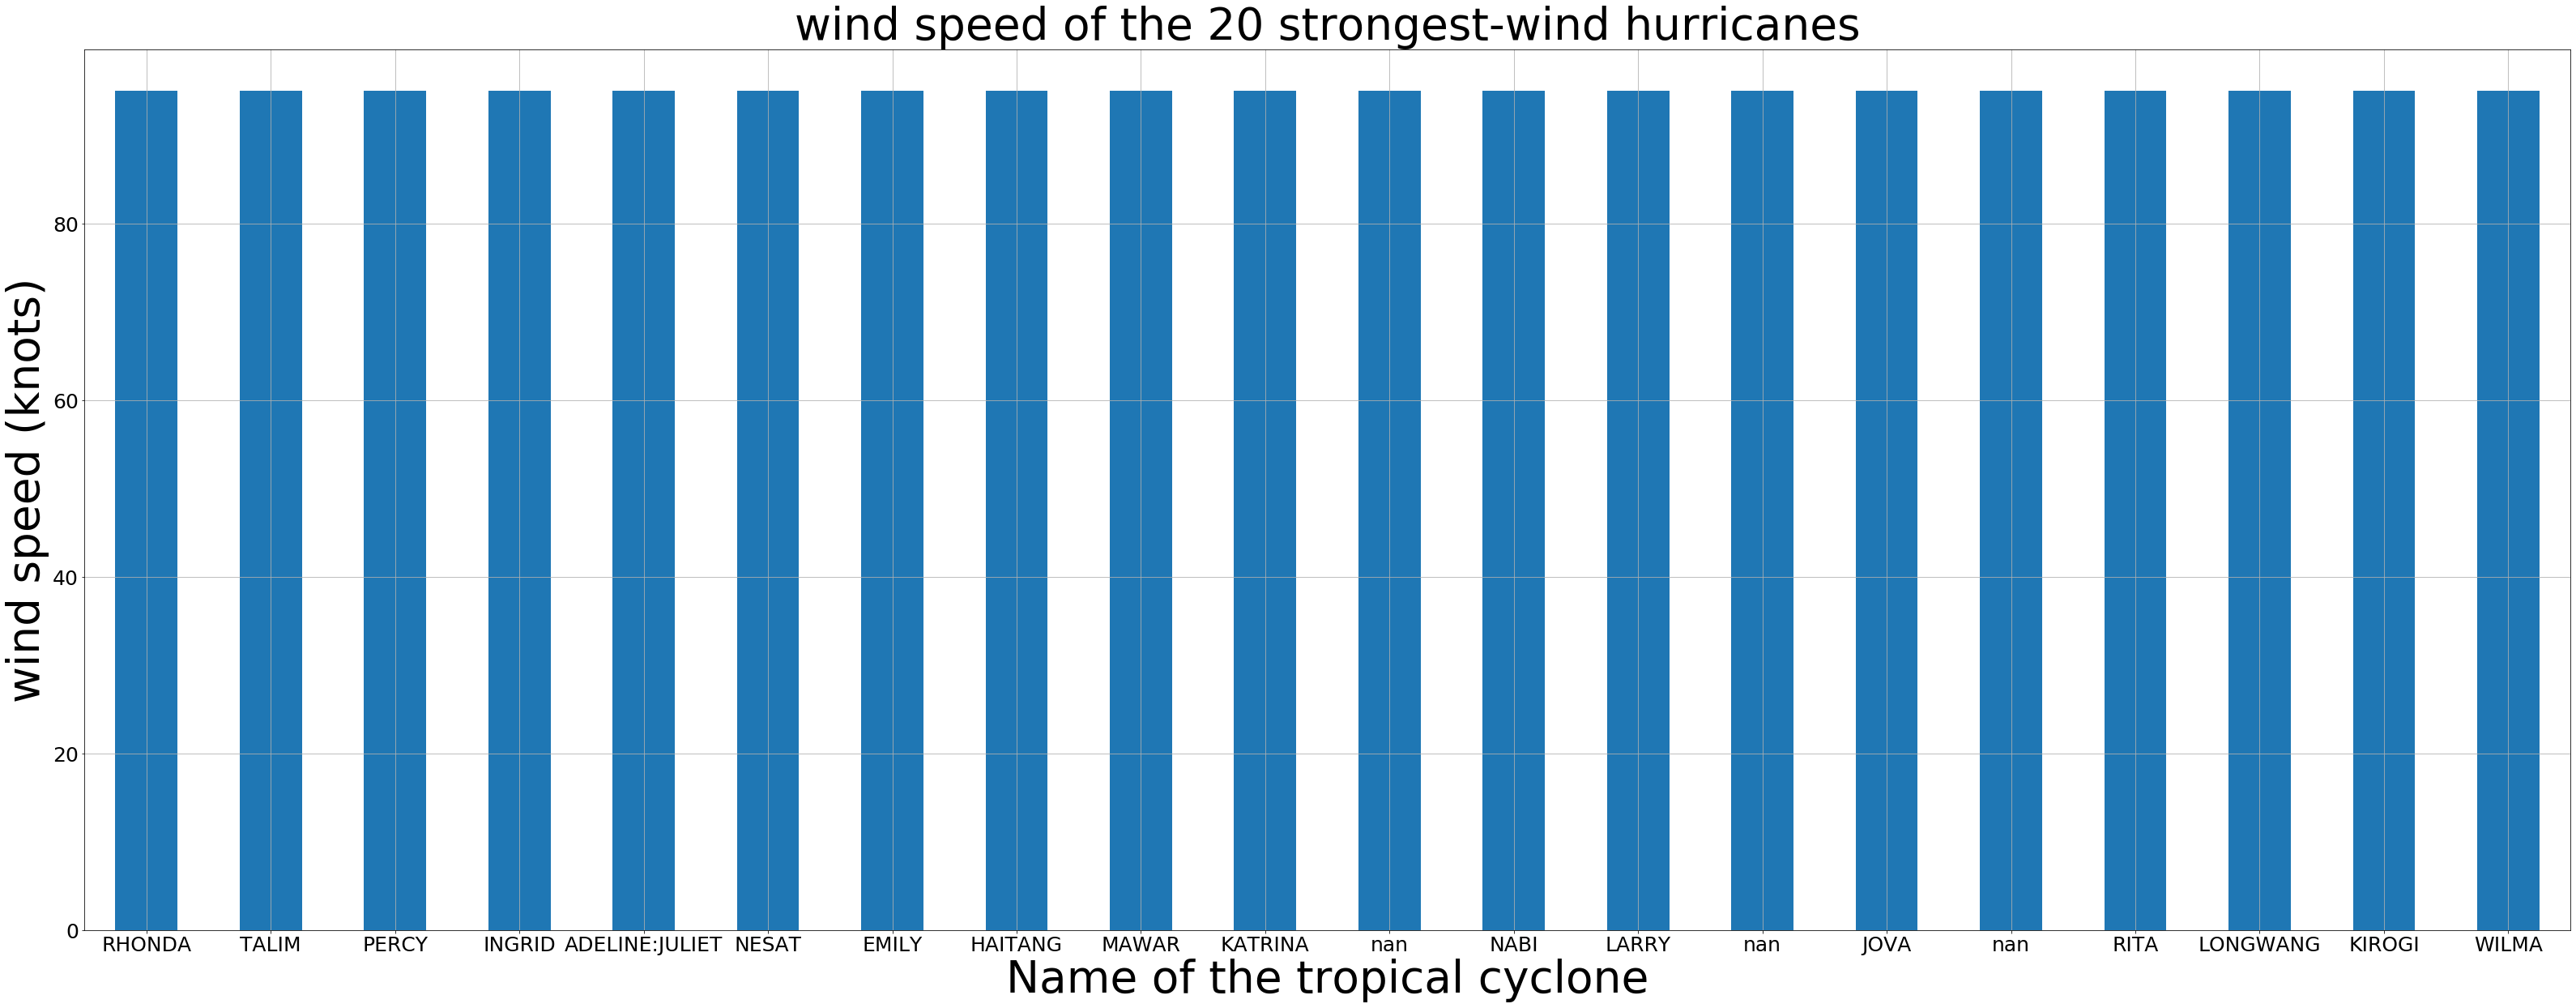

In [242]:
#空值处理
df['WMO_WIND'].fillna(0)

#统计风力最强的前20飓风
largest_df20 = df.groupby(['SID']).max().sort_values('WMO_WIND',ascending=False)[0:20]
largest_df20['WMO_WIND'] = largest_df20['WMO_WIND'].astype('float')

#画出
plt.figure(figsize=(400,10))
ax = largest_df20.plot(kind='bar',x='NAME',y='WMO_WIND',rot=0,figsize=(55,20),legend=None)
ax.set_xlabel('Name of the tropical cyclone',fontsize=55)
ax.set_ylabel('wind speed (knots)',fontsize=55)
ax.set_title('wind speed of the 20 strongest-wind hurricanes',fontsize=55)
plt.tick_params(labelsize=25)
plt.grid()

### 3.3

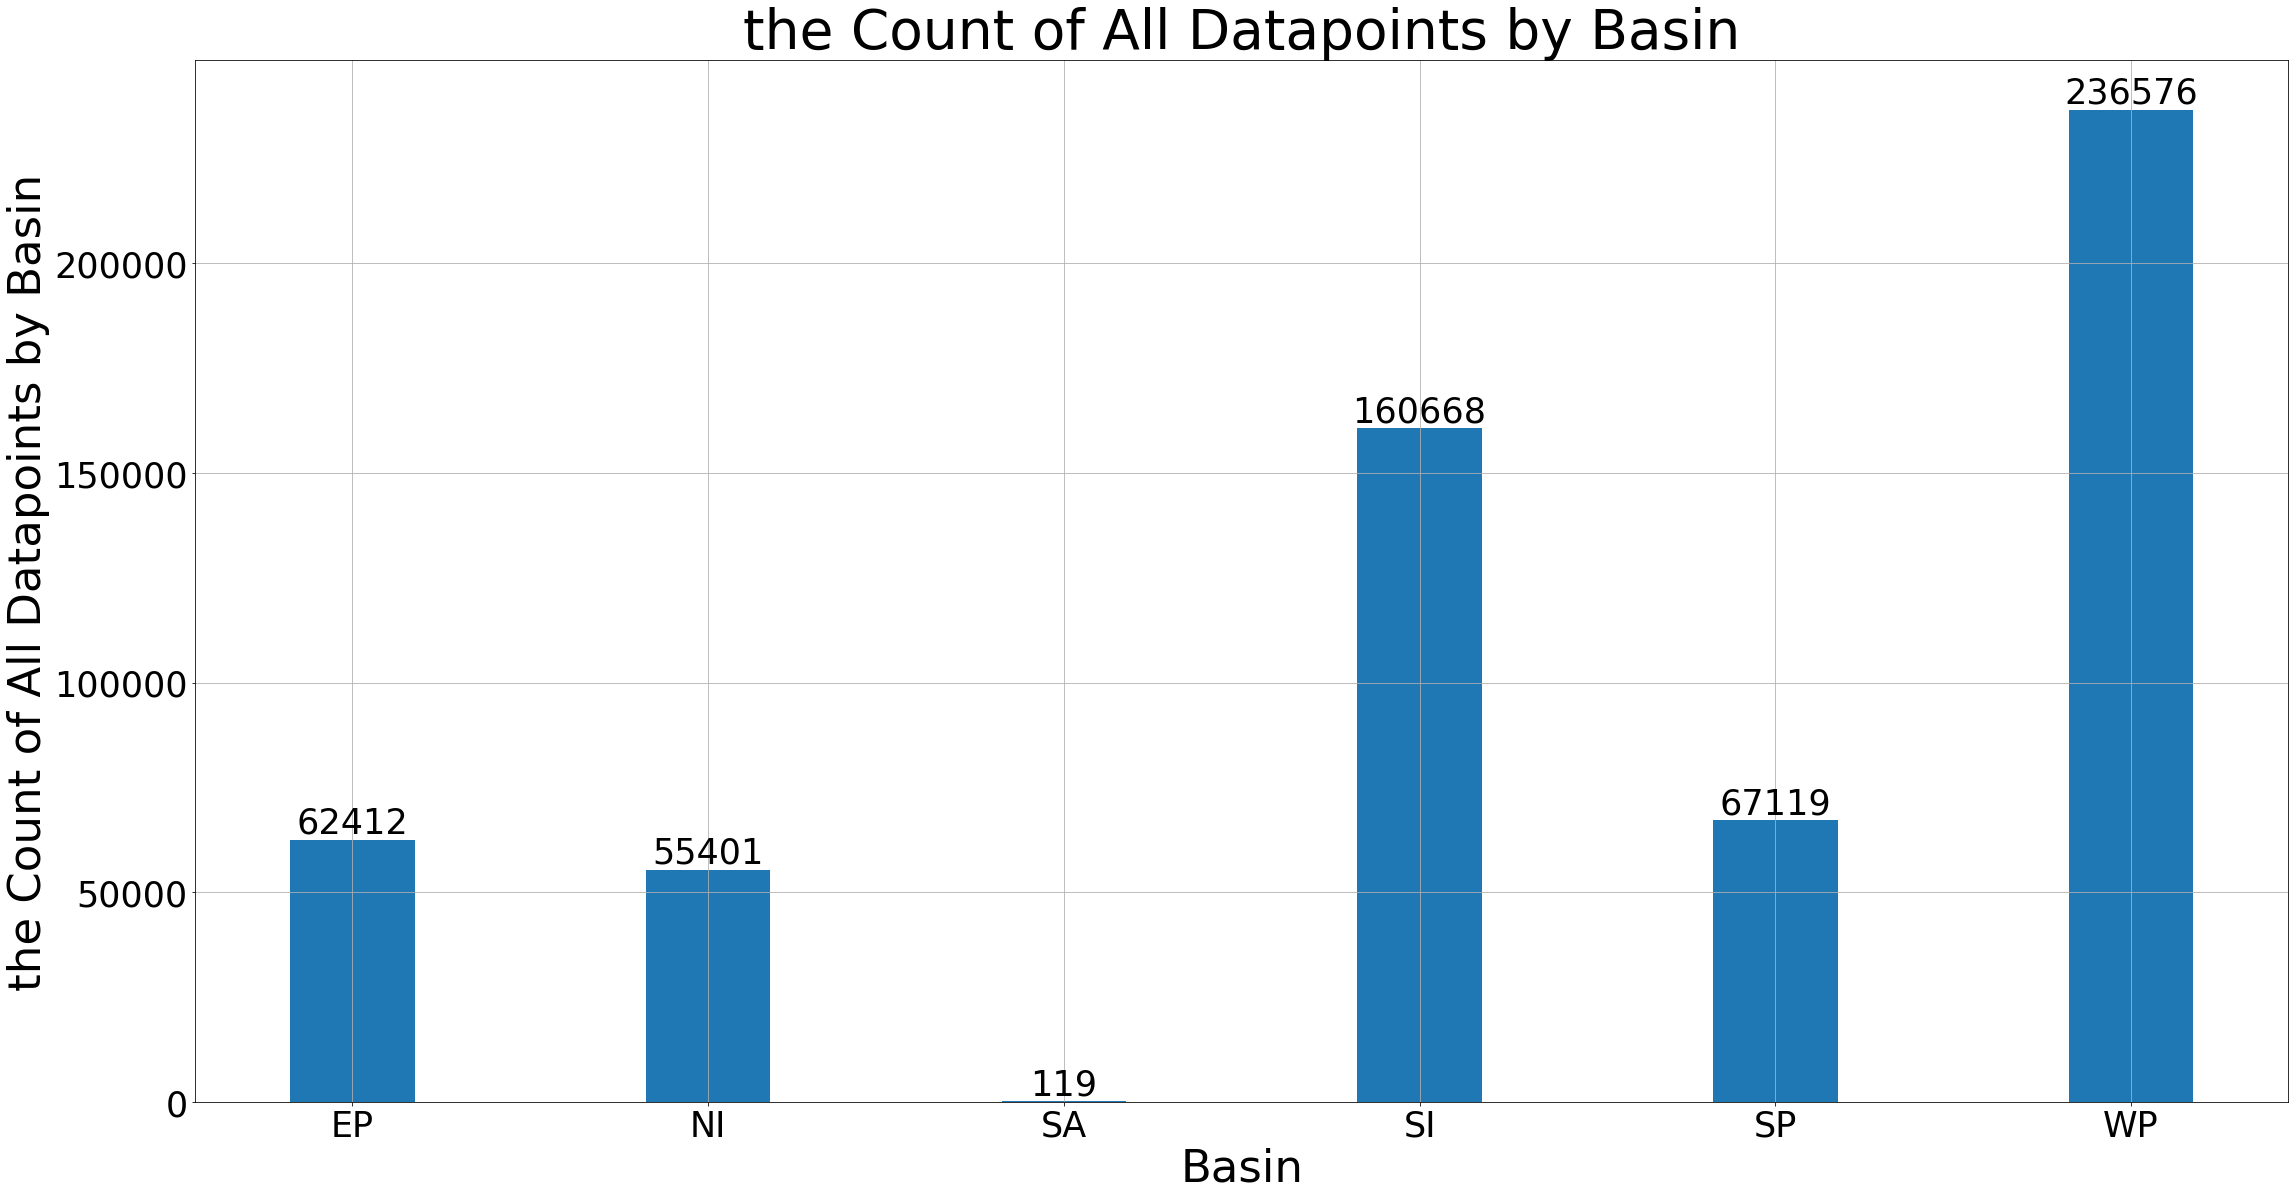

In [44]:
#存成一个新series df3
df3 =  df.groupby(['BASIN']).count()['SID']

#画图
fig  = plt.figure(figsize=(30,15))
ax = fig.add_subplot(1,1,1)
x, y = df3.index, df3.values
rects = plt.bar(x,y,width=0.35)
plt.grid()
plt.tight_layout()

#给每个条形顶部标上数据
for rect in rects:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2, height, str(height), size =35, ha = 'center', va = 'bottom')
plt.title('the Count of All Datapoints by Basin',fontsize=55)
plt.xlabel('Basin',fontsize=45)
plt.ylabel('the Count of All Datapoints by Basin',fontsize=45)
plt.tick_params(labelsize=35)


### 3.4

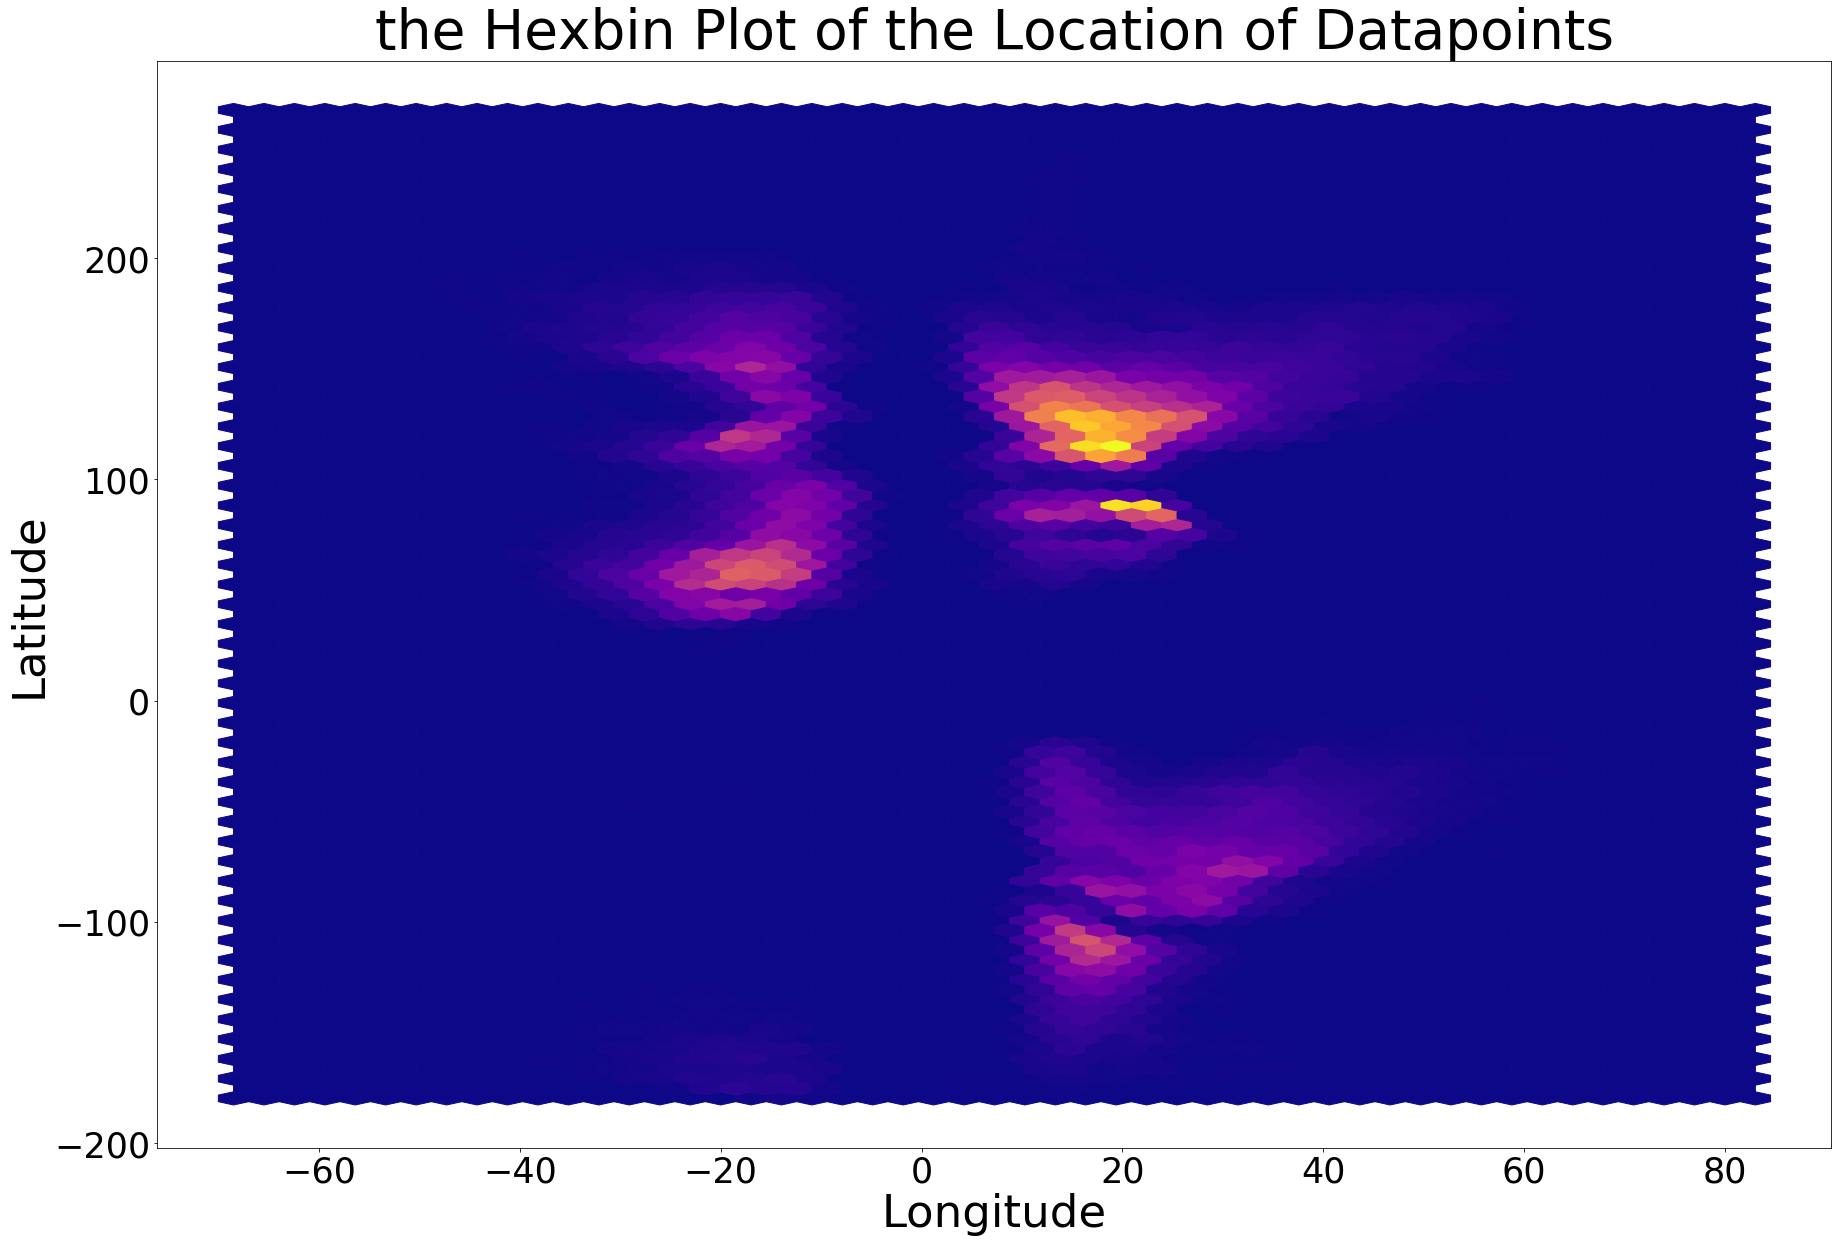

In [45]:
fig  = plt.figure(figsize=(30,20))
plt.hexbin(df['LAT'], df['LON'], gridsize=(50,50), cmap=plt.cm.plasma)
plt.title('the Hexbin Plot of the Location of Datapoints',fontsize=55)
plt.xlabel('Longitude',fontsize=45)
plt.ylabel('Latitude',fontsize=45)
plt.tick_params(labelsize=35)

### 3.5

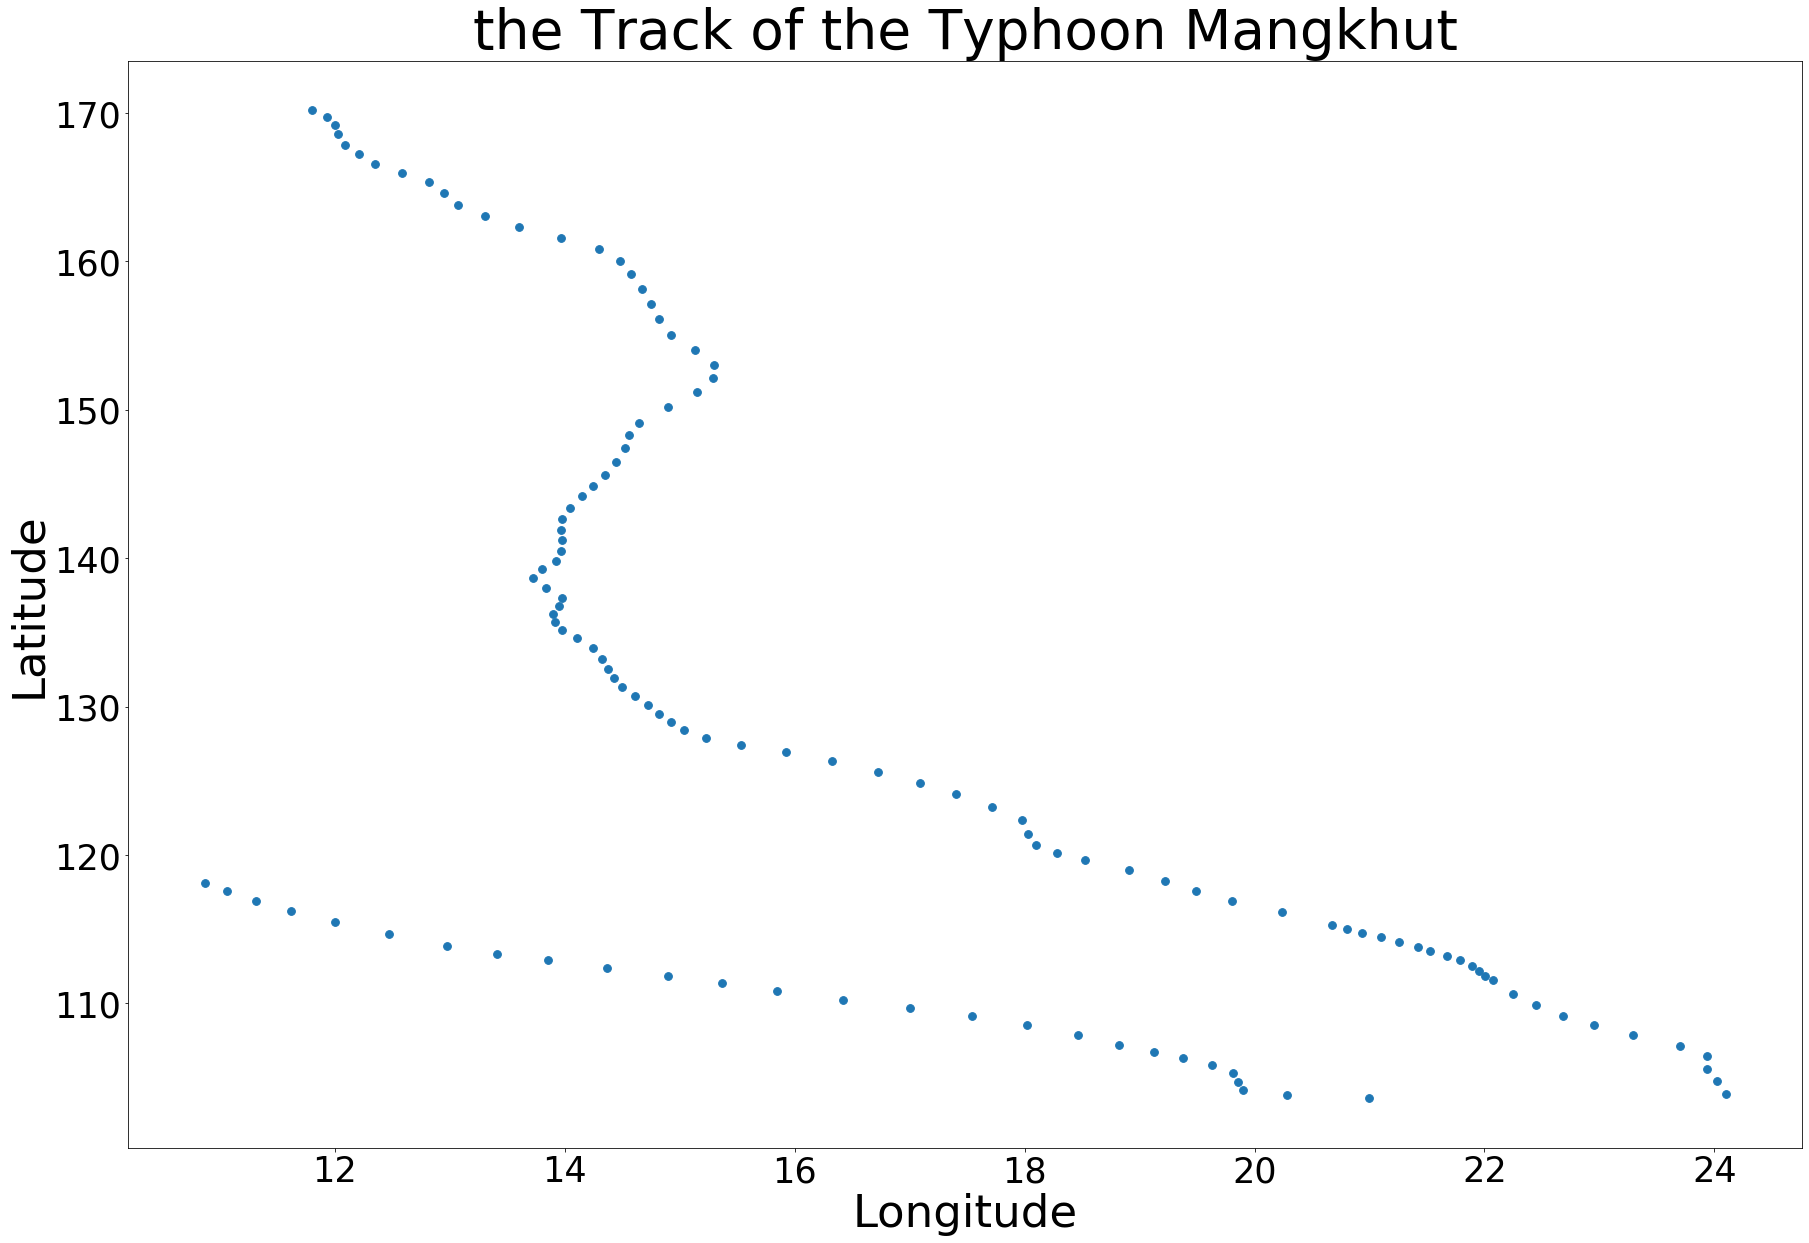

In [40]:
#删去没有name信息的行
#注意这一行原位删除了nan值，3.6以后要重新读进df再操作
df.dropna(axis=0,subset = ['NAME'],inplace=True)

#筛选山竹的信息并存成新的df
df5 = df.loc[ df['NAME'].str.contains('MANGKHUT') ]

#画图
fig  = plt.figure(figsize=(30,20))
plt.scatter(df5['LAT'], df5['LON'], cmap=plt.cm.plasma ,s=60)
plt.title('the Track of the Typhoon Mangkhut',fontsize=55)
plt.xlabel('Longitude',fontsize=45)
plt.ylabel('Latitude',fontsize=45)
plt.tick_params(labelsize=35)

### 3.6

In [149]:
#筛选出1970年之后北太平洋东西部的台风数据点
df_filt = df.loc[ (df['SEASON'] >= 1970) & ((df['BASIN'].str.contains("WP")) | (df['BASIN'].str.contains("EP"))) ]
df_filt.head()

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,WMO_WIND,WMO_PRES,WMO_AGENCY,TRACK_TYPE,DIST2LAND,LANDFALL,IFLAG
350393,1970050N07151,1970,22,WP,MM,NANCY,1970-02-19 00:00:00,TS,7.00000,151.400,,1006,tokyo,main,1088,1088,_OO___________
350394,1970050N07151,1970,22,WP,MM,NANCY,1970-02-19 03:00:00,TS,7.24752,151.205,,,,main,1109,1109,_PP___________
350395,1970050N07151,1970,22,WP,MM,NANCY,1970-02-19 06:00:00,TS,7.50000,151.000,,1002,tokyo,main,1143,1143,_OO___________
350396,1970050N07151,1970,22,WP,MM,NANCY,1970-02-19 09:00:00,TS,7.75747,150.772,,,,main,1171,1168,_PP___________
350397,1970050N07151,1970,22,WP,MM,NANCY,1970-02-19 12:00:00,TS,8.00000,150.500,,998,tokyo,main,1182,1179,_OO___________


### 3.7

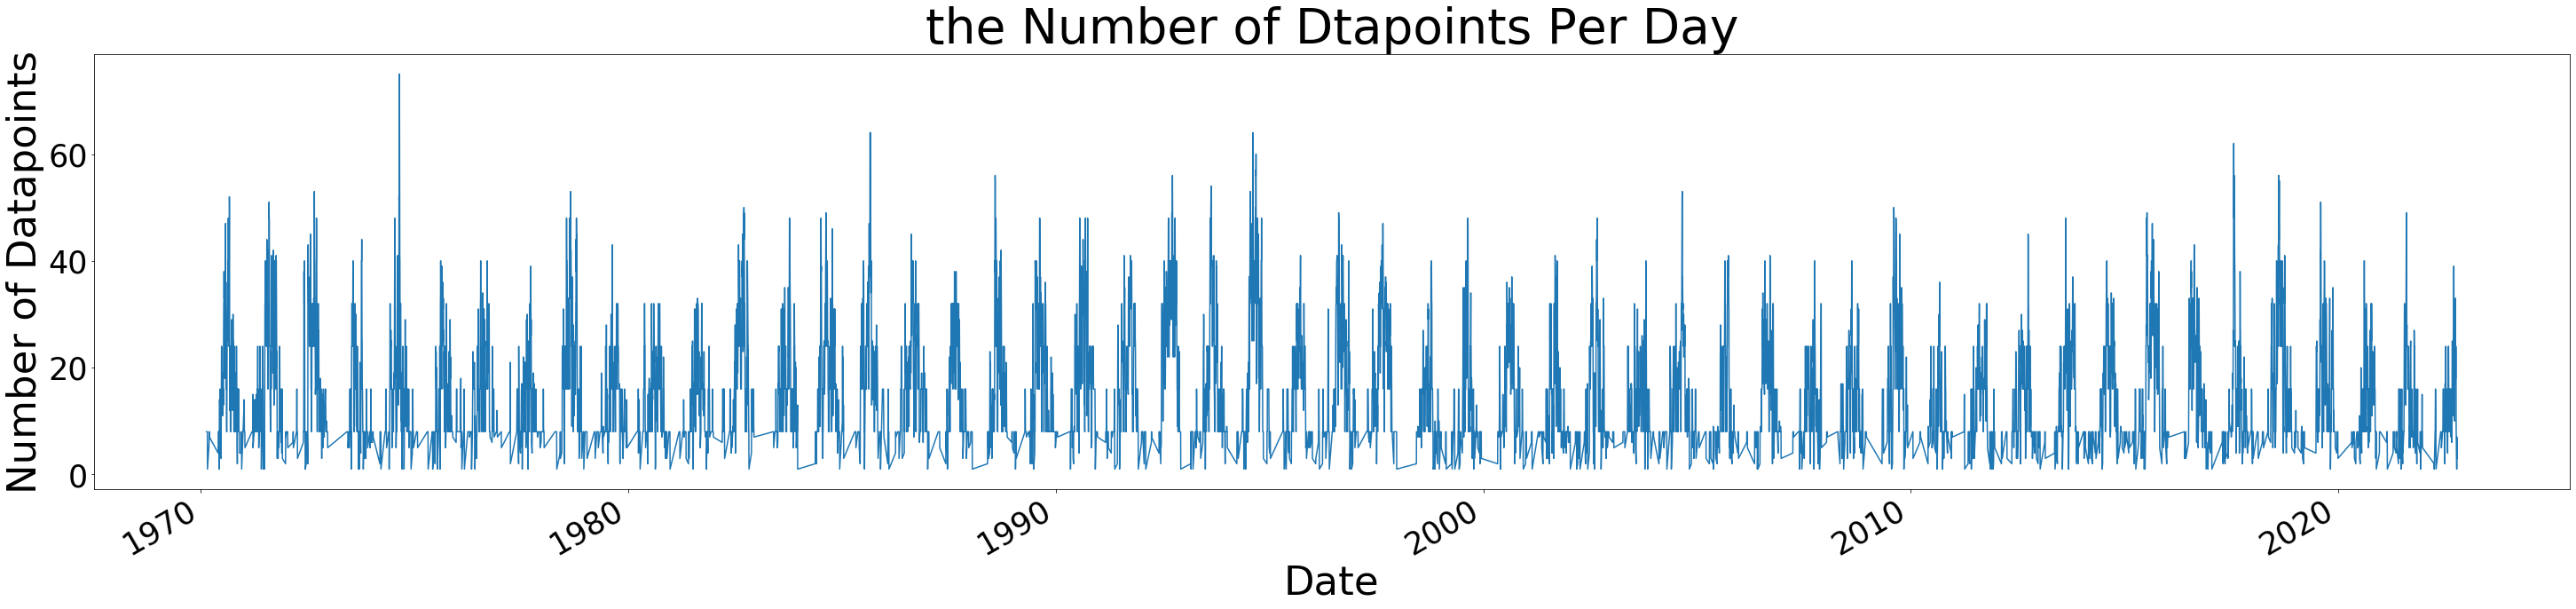

In [89]:
#按照年月日信息画图
plt.figure()
ax= df_filt.groupby(df_filt.ISO_TIME.values.astype("datetime64[D]")).count()['SID'].plot(figsize=(50,10))
plt.title('the Number of Dtapoints Per Day',fontsize=55)
ax.set_xlabel('Date',fontsize=45)
ax.set_ylabel('Number of Datapoints',fontsize=45)
plt.tick_params(labelsize=35)

**Ref:**The usage of datetime is referred to the blog by *XH生信ML笔记*(https://blog.csdn.net/weixin_44022515/article/details/109095448).

### 3.8

In [185]:
#先通过年月日统计数据点个数，将年月日、统计点数两列存成新的dataframe：df88
df8 = df_filt.groupby(df_filt.ISO_TIME.values.astype("datetime64[D]")).count()['SID']
df88 = pd.DataFrame({'date':df8.index,'climatology':df8.values})

#增加新列，为参数day of year，然后算平均值即为climatology
df88['day_of_year'] = df88['date'].dt.dayofyear
df88.groupby(['day_of_year']).mean()

,climatology
day_of_year,
1,7.545455
2,8.000000
3,6.727273
4,7.750000
5,8.750000
...,...
362,8.315789
363,6.947368
364,8.000000


**Ref:**The usage of the function to caculate the variable (day of year) was referred to the sharing by *ZACH* on *STATOLOGY* website (https://www.statology.org/pandas-get-day-of-year-from-date/).

### 3.9

In [206]:
#df88更改列名
df88.rename(columns = {'climatology':'count'},inplace=True)

#将day_of_year和climatology存成一个新df9
df9 = pd.DataFrame({'day_of_year':series_clima.index,'climatology':series_clima['climatology']})
#df9

#df_filt也增加新列，用于之后的join
df_filt['day_of_year'] = df_filt['ISO_TIME'].dt.dayofyear
#df_filt

#通过指定的列“day_of_year”将df9 join到df88上得到新df99
df99 = df88.set_index('day_of_year').join(df9.set_index('day_of_year'))

#增加新列，计算anomaly
df99['anomaly'] = df99['count']-df99['climatology']
df99

D:\anaconda\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,date,count,climatology,anomaly
day_of_year,,,,
1,1978-01-01,8,7.545455,0.454545
1,1979-01-01,8,7.545455,0.454545
1,1987-01-01,8,7.545455,0.454545
1,1994-01-01,9,7.545455,1.454545
1,1996-01-01,8,7.545455,0.454545
...,...,...,...,...
365,2015-12-31,8,8.454545,-0.454545
365,2017-12-31,8,8.454545,-0.454545
365,2018-12-31,8,8.454545,-0.454545


**Ref:** The usage of *.join()* function was referred to the blog by *会飞的哼哧* (https://blog.csdn.net/qq_38233659/article/details/94666134). Besides, the usage of function *.rename()* was referred to the blog by *Asher117* (https://blog.csdn.net/Asher117/article/details/84791257).

### 3.10

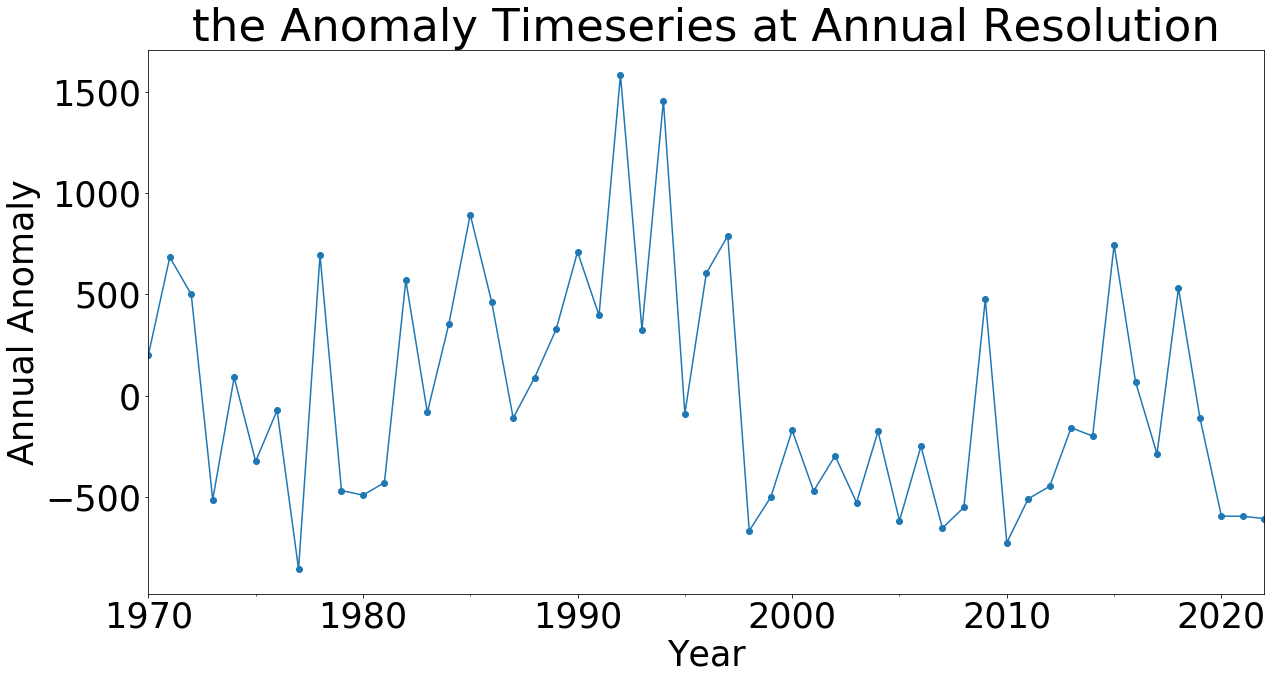

In [215]:
#另存为一个series
df10 = pd.Series(df99['anomaly'].tolist(), index=df99['date'].tolist())

#按年份重采样并画图
plt.figure()
ax10 = df10.resample('Y', label='right').sum().plot(figsize=(20,10),marker='o')
plt.title('the Anomaly Timeseries at Annual Resolution',fontsize=45)
ax10.set_xlabel('Year',fontsize=35)
ax10.set_ylabel('Annual Anomaly',fontsize=35)
plt.tick_params(labelsize=35)

In [224]:
#将飓风活动最不活跃/最活跃的前五名分别存成列表
min_lst = df10.resample('Y', label='right').sum().sort_values(ascending=True)[0:5].index.year.tolist()
max_lst = df10.resample('Y', label='right').sum().sort_values(ascending=False)[0:5].index.year.tolist()

#打印
print("The five most active years for hurricanes are:"+str(max_lst))
print("The five least active years for hurricanes are:"+str(min_lst))
print("The above 10 years stand out as having anomalous hurricane activity.")

The five most active years for hurricanes are:[1992, 1994, 1985, 1997, 2015]
The five least active years for hurricanes are:[1977, 2010, 1998, 2007, 2005]
The above 10 years stand out as having anomalous hurricane activity.


**Ref:**The usage of function *.resample()* was referred to the official website of *pandas* (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html).

## 4. Explore a data set

The data of production and released CFC11 during 1931-2003 was used in this item. And the data was downloaded from Advanced Global Atomspheric Gases Experiment (https://agage.mit.edu/data/afeas-data).

### 4.1 

In [384]:
#读入数据并查看
df = pd.read_excel("em-cfc-11.xls")
df.head()

,Table 1:,Production and Atmospheric Release,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Expanded Data,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,CFC-11,(thousand metric tonnes),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,(thousand metric tonnes),NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Cumulative,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Annual,NaN,NaN,Total,NaN,NaN,NaN,Refrigeration hermetic,NaN,...,NaN,NaN,NaN,Blowing Agents Closed Cell Foam,NaN,NaN,NaN,"Open Cell Foam, Aerosols & Others",NaN,NaN
3,NaN,Production,Released,NaN,Production,Released,Unreleased,NaN,Sales,Released,...,Released,Unreleased,NaN,Sales,Released,Unreleased,NaN,Sales,Released,Unreleased
4,1931,0,0,NaN,0,0,0,NaN,0,0,...,0,0,NaN,0,0,0,NaN,0,0,0


In [385]:
#数据清洗，只需要前三列
df.drop(index=df.index[[0,1,2,3]],axis=1,inplace=True)
df.dropna(subset=['Production and Atmospheric Release'],inplace=True)
df.reset_index(drop=True,inplace=True)
df.drop(df.columns[list(range(3,23,1))],axis = 1,inplace = True)

#改列名字
df.rename(columns = {'Table 1:':'year','Production and Atmospheric Release':'production','Unnamed: 2':'released'},inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73 entries, 0 to 72
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   year        73 non-null     object
 1   production  73 non-null     object
 2   released    73 non-null     object
dtypes: object(3)
memory usage: 1.8+ KB


### 4.2

<Figure size 432x288 with 0 Axes>

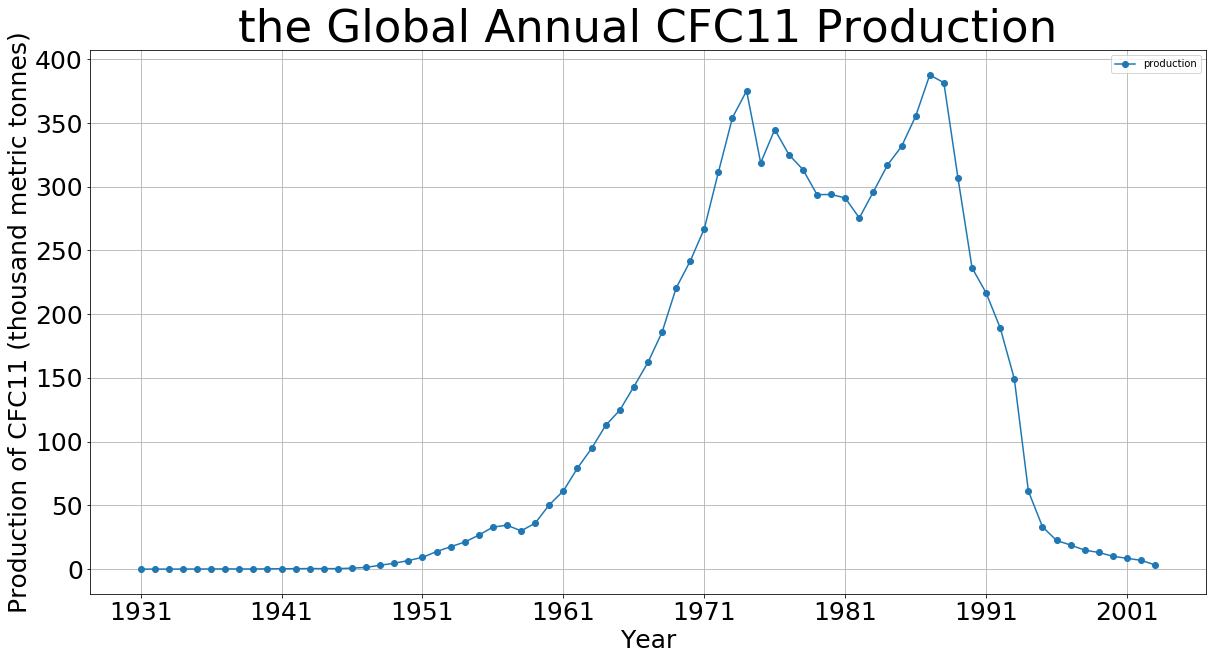

In [314]:
#画production的时间序列图
plt.figure()
ax = df.plot(x="year",y="production",figsize=(20,10),marker='o')
plt.title('the Global Annual CFC11 Production',fontsize=45)
ax.set_xlabel('Year',fontsize=25)
ax.set_ylabel('Production of CFC11 (thousand metric tonnes)',fontsize=25)
plt.grid()
plt.tick_params(labelsize=25)

### 4.3 

In [362]:
#4.3.1 打印生产和排放最多的年份前五
max_lst = df.sort_values(["production","released"],ascending=[0,0])['year'][0:5].values.tolist()

#打印
print("The five most CFC11 (both production and released) years for hurricanes are:")
print(str(max_lst))

The five most CFC11 (both production and released) years for hurricanes are:
['1987', '1988', '1974', '1986', '1973']


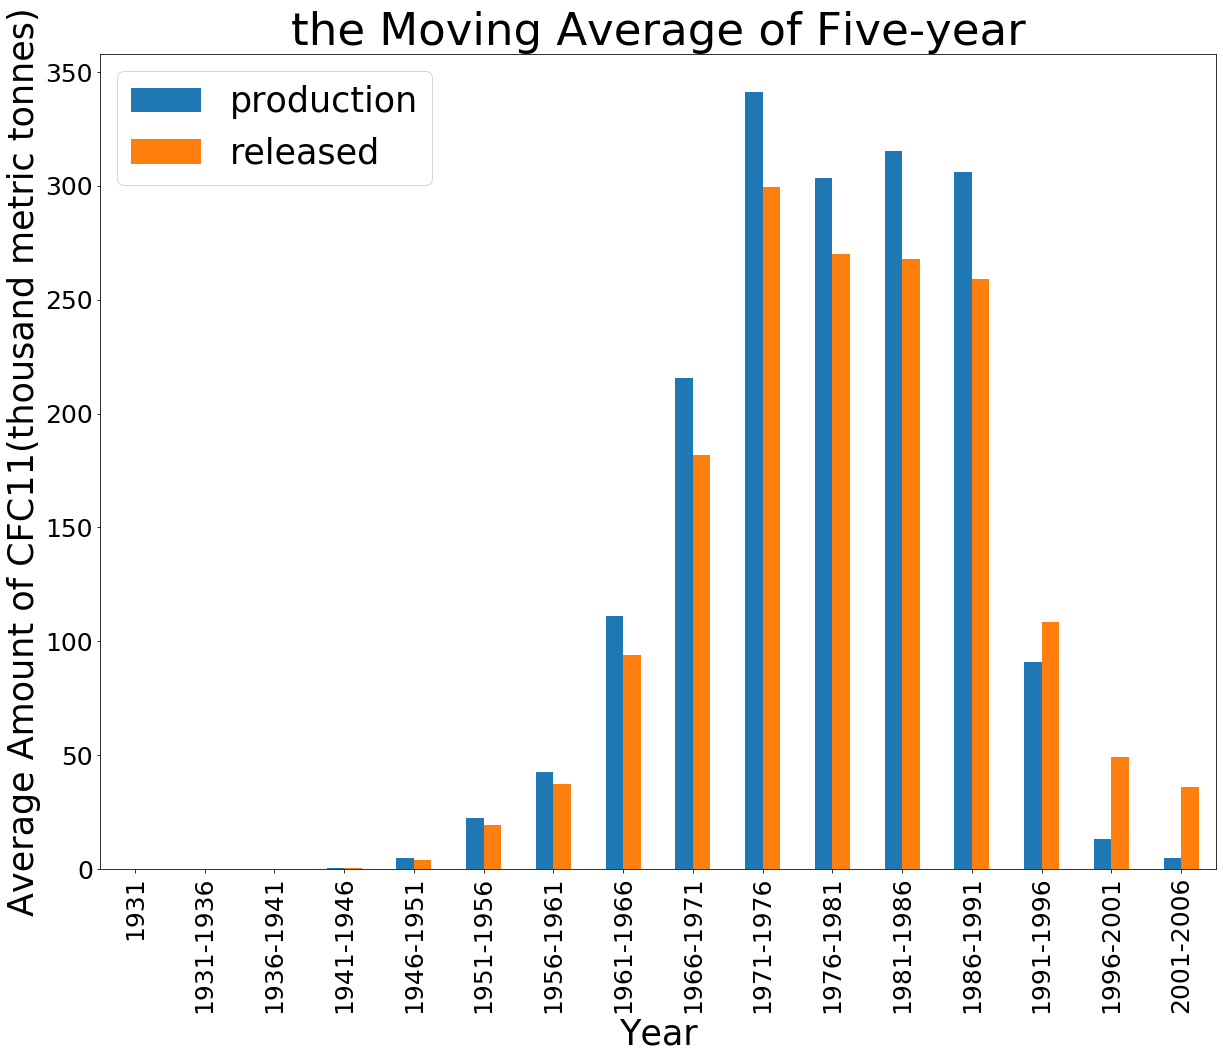

In [387]:
#4.3.2 滑动平均，五年一个
#先将日期改成datetime格式
time_data = pd.to_datetime(df['year'],format='%Y')
df_smooth = pd.DataFrame({'year':time_data.values,'production':df['production'],'released':df['released']})
ax = df_smooth.groupby(pd.Grouper(key='year',axis=0,freq='5Y')).mean().plot(kind='bar',figsize=(20,15))
x = ['1931','1931-1936','1936-1941','1941-1946','1946-1951','1951-1956','1956-1961','1961-1966','1966-1971',
            '1971-1976','1976-1981','1981-1986','1986-1991','1991-1996','1996-2001','2001-2006']
plt.xlabel("Year",fontsize=35)
plt.ylabel("Average Amount of CFC11(thousand metric tonnes)",fontsize=35)
plt.title("the Moving Average of Five-year",fontsize=45)
plt.legend(fontsize=35)
plt.xticks(range(len(x)),x)
plt.tick_params(labelsize=25)

As shown in the figure above, the moving average of the production and released CFC11 amounts are negative skewness. That means that effective measures were implemented to reduce the CFC11 from the industrial production. And the speed of reducing CFC11 is faster than that of introducing CFC11 into the production. However, since the update of this dataset stopped in 2003, the above conclusion may not be correct.

<Figure size 432x288 with 0 Axes>

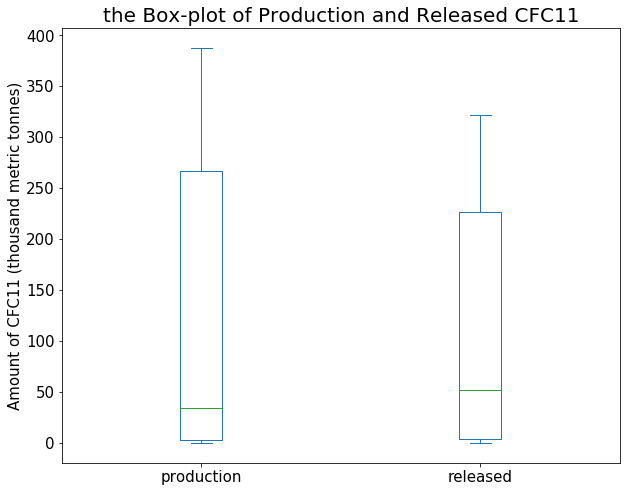

In [340]:
#4.3.3 画出production和released的box-plot
plt.figure()
ax = df[['production','released']].plot.box(figsize=(10,8))
plt.title('the Box-plot of Production and Released CFC11',fontsize=20)
ax.set_ylabel('Amount of CFC11 (thousand metric tonnes)',fontsize=15)
plt.tick_params(labelsize=15)

As shown in the figure above, both the production and reased CFC11 are concentrated on lower values, and their statistical characteristics are similar to each other (25th percentile, minimal......).

In [388]:
#4.2.4 计算二者的线性相关系数：
print(np.corrcoef(df['production'].tolist(),df['released'].tolist()))

[[1.         0.99189231]
 [0.99189231 1.        ]]


[[1.         0.99189231]
 [0.99189231 1.        ]]


<Figure size 432x288 with 0 Axes>

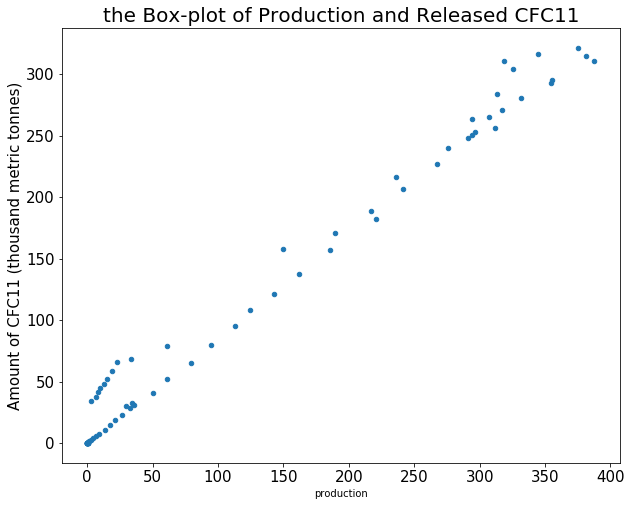

In [354]:
#4.3.5 画出production和released的散点图
plt.figure()
ax = df.plot.scatter(x='production',y='released',figsize=(10,8))
#pd.plotting.scatter_matrix(df,figsize=(10,10))

plt.title('the Box-plot of Production and Released CFC11',fontsize=20)
ax.set_ylabel('Amount of CFC11 (thousand metric tonnes)',fontsize=15)
plt.tick_params(labelsize=15)


As shown in figure above, production of CFC11 and released CFC11 have a strong linear relationship, and they are also positively correlation (shown as the computed result). This conclusion fits with the common sense: more production with more released.